In [5]:
'''
This Script analyzes a trained SpotTune model to understand the fine-tuning decisions being made
'''

import torch
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# import imdbfolder as imdbfolder
from spottune_models import *

from utils import *
from gumbel_softmax import *

from visda17 import get_visda_dataloaders
import shutil

load_path = 'spottune_visda_v2_best.ckpt'
device = 'cuda:0'

# Load the net and agent
ckpt = torch.load(load_path, map_location=device)
net = ckpt['net'].module
agent = ckpt['agent'].module

train_loader, val_loader, test_loader = get_visda_dataloaders(
    train_dir='/export/r32/data/visda17/train',
    val_dir='/export/r32/data/visda17/validation',
    test_dir='/export/r32/data/visda17/test',
    batch_size=256
)

net.eval()
agent.eval()

policies = [
    'adaptive',
    [],
    list(range(12)),
    [4, 8, 9, 10],
    [4, 8, 10],
    [8, 9, 10],
    [10],
    [4],
    [8],
    [9],
    [0]
]

for k_blocks in policies:
    tasks_top1 = AverageMeter()
    tasks_losses = AverageMeter() 

    with torch.no_grad():
        for i, (images, labels, paths) in enumerate(tqdm(test_loader)):
            if torch.cuda.is_available():
                images, labels = images.to(device=device,non_blocking=True), labels.to(device=device, non_blocking=True)
            images, labels = Variable(images), Variable(labels)

            probs = agent(images)
            action = gumbel_softmax(probs.view(probs.size(0), -1, 2))
            policy = action[:,:,1]

            # override the policy to simulate top-k spottune variant
            # k_blocks = [8]
            if k_blocks == 'adaptive':
                used_policy = policy
            else:
                used_policy = torch.zeros_like(policy)
                used_policy[:, k_blocks] = 1.0

            # ax = sns.heatmap(np.mean(policy.cpu().numpy(), dim=0), linewidth=0.5, cmap = sns.color_palette("crest_r"))
            # sns.set(rc = {'figure.figsize':(24,6)})
            # # plt.yticks(np.arange(len(model_names))+0.5, [f"{exp_name}\n{exp_acc:.2f}%" for exp_name, exp_acc in zip(model_names, accs)],
            # #         rotation=0, fontsize="10", va="center")
            # # plt.xticks(np.arange(on.shape[1]), model.getIndicatorLayers(), rotation=45, ha="right", va='center', rotation_mode='anchor')
            # plt.title("Adapted Layers", size = 'x-large')
            # plt.show()

            outputs = net.forward(images, used_policy)

            _, predicted = torch.max(outputs.data, 1)
            correct = predicted.eq(labels.data).cpu().sum()
            tasks_top1.update(correct.item()*100 / (labels.size(0)+0.0), labels.size(0))

            # break


    # print(f"Test accuracy: {tasks_top1.avg}")
    print(f"{str(k_blocks).ljust(20)} - {tasks_top1.avg}")
    # print(f"Test count: {tasks_top1.count}")

{'aeroplane': 0, 'bicycle': 1, 'bus': 2, 'car': 3, 'horse': 4, 'knife': 5, 'motorcycle': 6, 'person': 7, 'plant': 8, 'skateboard': 9, 'train': 10, 'truck': 11}


100%|██████████| 283/283 [00:24<00:00, 11.69it/s]


adaptive             - 69.23810313380865


 42%|████▏     | 120/283 [00:11<00:15, 10.55it/s]


KeyboardInterrupt: 

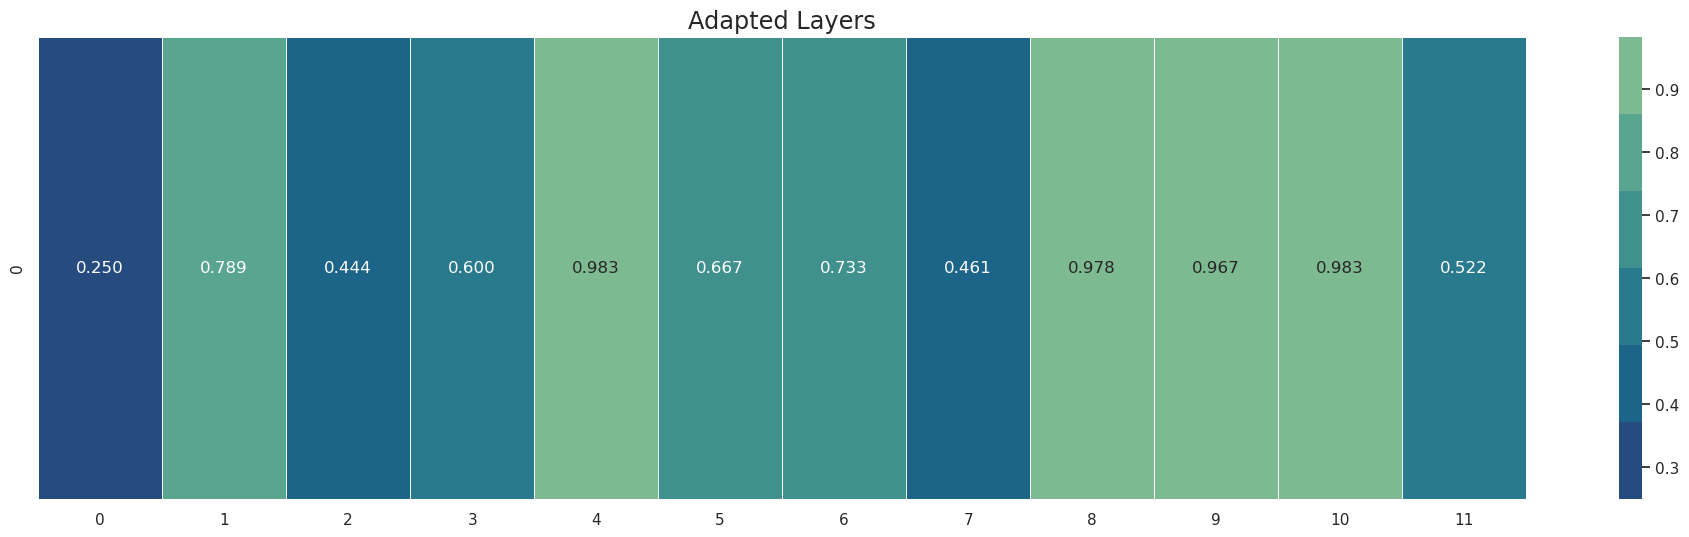

[[0.25       0.7888889  0.44444445 0.6        0.98333335 0.6666667
  0.73333335 0.4611111  0.9777778  0.96666664 0.98333335 0.5222222 ]]


In [18]:
ax = sns.heatmap(np.mean(policy.cpu().numpy(), axis=0, keepdims=True), annot=True, fmt='.3f', linewidth=0.5, cmap = sns.color_palette("crest_r"))
sns.set(rc = {'figure.figsize':(24,6)})
# plt.yticks(np.arange(len(model_names))+0.5, [f"{exp_name}\n{exp_acc:.2f}%" for exp_name, exp_acc in zip(model_names, accs)],
#         rotation=0, fontsize="10", va="center")
# plt.xticks(np.arange(on.shape[1]), model.getIndicatorLayers(), rotation=45, ha="right", va='center', rotation_mode='anchor')
plt.title("Adapted Layers", size = 'x-large')
plt.show()


print(np.mean(policy.cpu().numpy(), axis=0, keepdims=True))

In [11]:
new_policy = torch.zeros_like(policy)
new_policy[:,[1,2]] = 1

print(new_policy)

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')
